From: https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html#Transpose-Convolutions-and-Autoencoders

Transpose Convolutions and Autoencoders
In our discussions of convolutional networks, we always started with an image, then reduced the "resolution" of the image until we made an image-level prediction. Specifically, we focused on image level classification problems: is the image of a cat or a dog? Which of the 10 digits does this image represent? We always went from a large image, to a lower-dimensional representation of the image.

Some tasks require us to go in the opposite direction. For example, we may wish to make pixel-wise predictions about the content of each pixel in an image. Is this pixel part of the foreground or the background? Is this pixel a part of a car or a pedestrian? Problems that require us to label each pixel is called a pixel-wise prediction problem. These problems require us to produce an high-resolution "image" from a low-dimensional representation of its contents.

A similar task is the task of generating an image given a low-dimensional embedding of the image. For example, we may wish to produce a neural network model that generates images of hand-written digits not in the MNIST data set. A neural network model that learns to generate new examples of data is called a generative model.

In both cases, we need a way to increase the resolution of our hidden units. We need something akin to convolution, but that goes in the opposite direction. We will use something called a transpose convolution. Transpose convolutions were first called deconvolutions, since it is the ``inverse'' of a convolution operation. However, the terminology was confusing since it has nothing to do with the mathematical notion of deconvolution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

Convolution Transpose
First, let's illustrate how convolution transposes can be inverses'' of convolution layers.
We begin by creating a convolutional layer in PyTorch. This is the convolution that we will
try to find aninverse'' for.

In [2]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=8,
                 kernel_size=5)

To illustrate how convolutional layers work, we'll create a random tensor and see how the convolution acts on that tensor:

In [3]:
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 8, 60, 60])

A convolution transpose layer with the exact same specifications as above would have the ``reverse'' effect on the shape.

In [4]:
convt = nn.ConvTranspose2d(in_channels=8,
                           out_channels=8,
                           kernel_size=5)
convt(y).shape # should be same as x.shape

torch.Size([2, 8, 64, 64])

And it does! Notice that the weights of this convolution transpose layer are all random, and are unrelated to the weights of the original Conv2d. So, the layer convt is not the mathematical inverse of the layer conv. However, with training, the convolution transpose has the potential to learn to act as an approximate inverse to conv.

Here is another example of convt in action:

In [5]:
x = torch.randn(32, 8, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 68, 68])

Notice that the width and height of y is 68x68, because the kernel_size is 5 and we have not added any padding. You can verify that if we start with a tensor with resolution 68x68 and applied a 5x5 convolution, we would end up with a tensor with resolution 64x64.

In [6]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=16,
                 kernel_size=5)
y = torch.randn(32, 8, 68, 68)
x = conv(y)
x.shape

torch.Size([32, 16, 64, 64])

As before, we can add a padding to our convolution transpose, just like we added padding to our convolution operations:

In [7]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 64, 64])

More interestingly, we can add a stride to the convolution to increase our resolution!

In [8]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           stride=2,
                           output_padding=1, # needed because stride=2
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 128, 128])

Our resolution has doubled.

But what is actually happening? Essentially, we are adding a padding of zeros in between every row and every column of x. In the picture below, the blue image below represents the input x to the convolution transpose, and the green image above represents the output y.



You can check https://github.com/vdumoulin/conv_arithmetic for more pictures and links to descriptions

Autoencoder¶
To demonstrate the use of convolution transpose operations, we will build an autoencoder.

An autoencoder is not used for supervised learning. We will no longer try to predict something about our input. Instead, an autoencoder is considered a generative model: it learns a distributed representation of our training data, and can even be used to generate new instances of the training data.

An autoencoder model contains two components:

An encoder that takes an image as input, and outputs a low-dimensional embedding (representation) of the image.
A decoder that takes the low-dimensional embedding, and reconstructs the image.
An autoencoder is typically shown like below: (image from https://hackernoon.com/how-to-autoencode-your-pok%C3%A9mon-6b0f5c7b7d97 )



Here is an example of a convolutional autoencoder: an autoencoder that uses solely convolutional layers:

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Notice that the final activation on the decoder is a sigmoid activation. The reason is that all of our image pixels are in the range [0, 1]. A sigmoid gives us results in the same range.



Training an Autoencoder¶
How do we train an autoencoder? How do we know what kind of "encoder" and "decoder" we want?

One observation is that if we pass an image through the encoder, then pass the result through the decoder, we should get roughly the same image back. Ideally, reducing the dimensionality and then generating the image should give us the same result.

This observation provides us a training strategy: we will minimize the reconstruction error of the autoencoder across our training data. We use a loss function called MSELoss, which computes the square error at every pixel.

Beyond using a different loss function, the training scheme is roughly the same. Note that in the code below, we are using a new optimizer called Adam.

We switched to this optimizer not because it is specifically used for autoencoders, but because this is the optimizer that people tend to use in practice for convolutional neural networks. Feel free to use Adam for your other convolutional networks.

We are also saving the reconstructed images of the last iteration in every epoch. We want to look at these reconstructions at the end of training.

In [10]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

Now, we can train this network.



In [11]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0683
Epoch:2, Loss:0.0657
Epoch:3, Loss:0.0469
Epoch:4, Loss:0.0332
Epoch:5, Loss:0.0256
Epoch:6, Loss:0.0194
Epoch:7, Loss:0.0169
Epoch:8, Loss:0.0159
Epoch:9, Loss:0.0150
Epoch:10, Loss:0.0117
Epoch:11, Loss:0.0091
Epoch:12, Loss:0.0094
Epoch:13, Loss:0.0107
Epoch:14, Loss:0.0084
Epoch:15, Loss:0.0077
Epoch:16, Loss:0.0078
Epoch:17, Loss:0.0075
Epoch:18, Loss:0.0067
Epoch:19, Loss:0.0064
Epoch:20, Loss:0.0067


The loss goes down as we train, meaning that our reconstructed images look more and more like the actual images!

Let's look at the training progression: that is, the reconstructed images at various points of training:

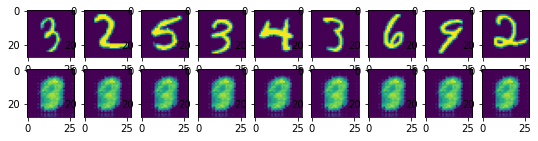

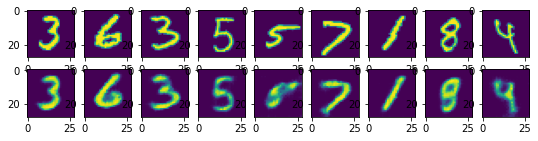

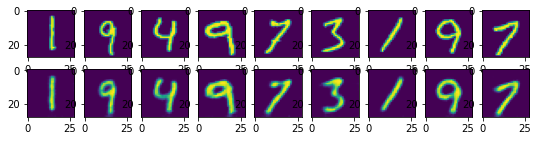

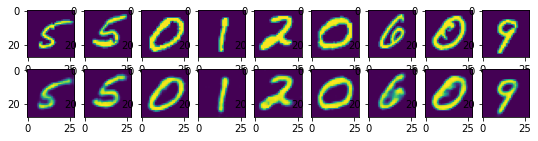

In [12]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

At first, the reconstructed images look nothing like the originals. Rather, the reconstructions look more like the average of some training images. As training progresses, our reconstructions are clearer.

Structure in the Embeddings
Since we are drastically reducing the dimensionality of the image, there has to be some kind of structure in the embedding space. That is, the network should be able to "save" space by mapping similar images to similar embeddings.

We will demonstrate the structure of the embedding space by hving some fun with our autoencoders. Let's begin with two images in our training set. For now, we'll choose images of the same digit.

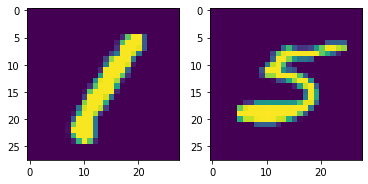

In [13]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

# Make similarity matching function

In [14]:
#have it just be the total difference between two images...extremely simple computationally (and then maybe RMS...)

In [15]:
testImage = mnist_data[5][0]

In [16]:
a1 = [1,4,50]

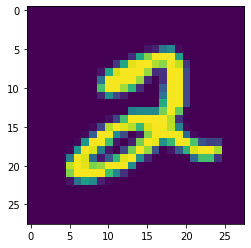

In [17]:
plt.imshow(testImage[0])

In [18]:
output = model(testImage).detach().numpy()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


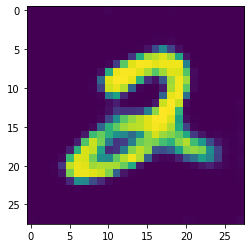

In [19]:
plt.imshow(output[0])

In [20]:
score = testImage[0] - output[0]
torch.sum(-score)

tensor(5.8470)

# Change reward from processing log_pi, log_prob to log_pi + generated image

In [21]:
torch.randn

<function torch._VariableFunctionsClass.randn>

In [22]:
log_pi = torch.randn(8, 15) #batch size: 8, 15 glimpses
baselines = torch.randn(8,15)
log_probas = torch.randn(8,10)
y = torch.randint(0, 2, (8,))
predicted = torch.randint(0, 2, (8,))
print(y)

tensor([0, 1, 1, 1, 1, 1, 0, 0])


In [23]:
print(len(mnist_data))

4096


In [24]:
random_indices = torch.randperm(4096)[:8]
random_indices

tensor([3446, 1594, 2731, 3139, 3465,  292, 2144, 3574])

In [25]:
xList = []
for i in random_indices:
    xList.append(mnist_data[i][0])

x = torch.stack(xList, dim=0)
x.shape

torch.Size([8, 1, 28, 28])

In [26]:
pred = model(x).detach().numpy()
pred.shape

(8, 1, 28, 28)

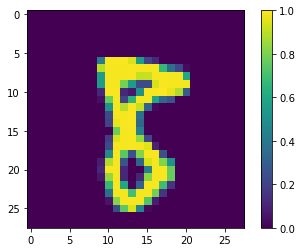

In [27]:
plt.imshow(x[0,0])
plt.colorbar()

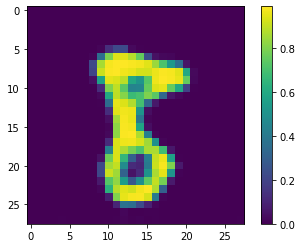

In [28]:
plt.imshow(pred[0,0])
plt.colorbar()

In [29]:
diff = torch.abs(x-pred)/torch.numel(x[0]) #normalize by 784
R = -torch.sum(diff, dim=(1, 2, 3))

In [30]:
torch.numel(x[0])

784

In [31]:
torch.sum(torch.abs(x[0,0] - pred[0,0]))

tensor(21.9536)

In [32]:
print(log_pi.shape) #8x15
print(baselines.shape) #8x15
print(log_probas.shape) #8x10
print(y.shape)
print(x.shape)
print(R.shape)

torch.Size([8, 15])
torch.Size([8, 15])
torch.Size([8, 10])
torch.Size([8])
torch.Size([8, 1, 28, 28])
torch.Size([8])


In [33]:
# calculate reward
#R = (predicted.detach() == y).float()
#print(R.shape)
R = R.unsqueeze(1).repeat(1, 15)
print(R.shape) #repeat for every glimpse


torch.Size([8, 15])


In [34]:
print(torch.sum(diff))

tensor(0.2106)


In [35]:
torch.sum(R)/15 - torch.sum(-diff) #basically 0, as expected

tensor(1.4901e-08)

In [36]:
# compute losses for differentiable modules

loss_action = -torch.sum(diff) #just total sum of abs difference between real image and predicted
print(y.shape)
print(log_probas.shape)
print(loss_action)
loss_baseline = F.mse_loss(baselines, R)

torch.Size([8])
torch.Size([8, 10])
tensor(-0.2106)


In [37]:
# compute reinforce loss
# summed over timesteps and averaged across batch

adjusted_reward = R - baselines.detach()

loss_reinforce = torch.sum(-log_pi * adjusted_reward, dim=1)
loss_reinforce = torch.mean(loss_reinforce, dim=0)

# sum up into a hybrid loss
loss = loss_action + loss_baseline + loss_reinforce * 0.01


In [38]:
print(loss)

tensor(0.5336)


In [39]:
loss_reinforce

tensor(-1.0929)

In [40]:
loss_baseline

tensor(0.7551)

In [41]:
loss_action

tensor(-0.2106)